# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

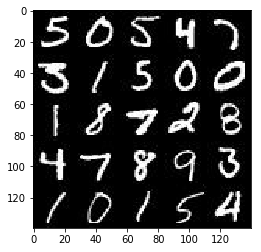

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

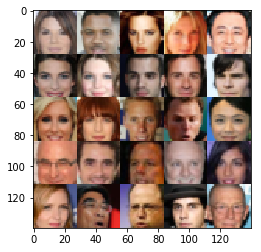

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, shape=(None,image_width,image_height,image_channels), name='input_images')
    z_data = tf.placeholder(tf.float32, shape=(None,z_dim), name='z_data')
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')

    return input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    dropout = 0.5
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28xnum_channels
        conv1 = tf.layers.conv2d(images,128,5,strides=2,padding='same')
        relu1 = tf.maximum(alpha*conv1,conv1)
        drop1 = tf.nn.dropout(relu1,keep_prob=dropout)
        # 14x14x128

        conv2 = tf.layers.conv2d(drop1,256,5,strides=2,padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha*conv2,conv2)
        drop2 = tf.nn.dropout(relu2,keep_prob=dropout)
        # 7x7x256
        
        conv3 = tf.layers.conv2d(drop2,512,5,strides=2,padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha*conv3,conv3)
        drop3 = tf.nn.dropout(relu3,keep_prob=dropout)
        # 4x4x512
        
        flat = tf.reshape(drop3, (-1,4*4*512))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    dropout = 0.5
    with tf.variable_scope('generator', reuse=not is_train):
        # z_dim
        gen_input = tf.layers.dense(z,3*3*1024)
        gen_input = tf.reshape(gen_input,shape=(-1,3,3,1024))
        gen_input = tf.layers.batch_normalization(gen_input, training=is_train)
        input_relu = tf.maximum(alpha*gen_input,gen_input)
        input_drop = tf.nn.dropout(input_relu,keep_prob=dropout)
        
#         deconv0 = tf.layers.conv2d_transpose(input_drop,1024,5,strides=1, padding='same')
#         deconv0 = tf.layers.batch_normalization(deconv0, training=is_train)
#         relu0 = tf.maximum(alpha*deconv0,deconv0)
#         drop0 = tf.nn.dropout(relu0,keep_prob=dropout)
        # 3x3x512
        
#         deconv1 = tf.layers.conv2d_transpose(drop0,512,3,strides=2, padding='valid')
        deconv1 = tf.layers.conv2d_transpose(input_drop,512,3,strides=2, padding='valid')
        deconv1 = tf.layers.batch_normalization(deconv1, training=is_train)
        relu1 = tf.maximum(alpha*deconv1,deconv1)
        drop1 = tf.nn.dropout(relu1,keep_prob=dropout)
        # 7x7x256
        
        deconv2 = tf.layers.conv2d_transpose(drop1,256,5,strides=2, padding='same')
        deconv2 = tf.layers.batch_normalization(deconv2, training=is_train)
        relu2 = tf.maximum(alpha*deconv2,deconv2)
        drop2 = tf.nn.dropout(relu2,keep_prob=dropout)
        # 14x14x128
        
        deconv3 = tf.layers.conv2d_transpose(drop2,256,5,strides=1, padding='same')
        deconv3 = tf.layers.batch_normalization(deconv3, training=is_train)
        relu3 = tf.maximum(alpha*deconv3,deconv3)
        drop3 = tf.nn.dropout(relu3,keep_prob=dropout)
        # 14x14x128

        deconv4 = tf.layers.conv2d_transpose(drop3,out_channel_dim,5,strides=2, padding='same')
        output = tf.tanh(deconv4)
#         deconv3 = tf.layers.conv2d_transpose(drop2,out_channel_dim,5,strides=2, padding='same')
#         output = tf.tanh(deconv3)
        output = tf.divide(output,2)
        # 28x28xout_channel_dim


    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    label_smooth = 0.9
    gen_model = generator(input_z, out_channel_dim)
    dis_out_real, dis_logit_real = discriminator(input_real, reuse=False)
    dis_out_fake, dis_logit_fake = discriminator(gen_model, reuse=True)
    
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(dis_out_fake)*label_smooth,logits=dis_logit_fake), name='gen_loss')
    dis_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(dis_out_real)*label_smooth,logits=dis_logit_real), name='diss_loss_real')
    dis_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(dis_out_fake),logits=dis_logit_fake), name='diss_loss_fake')
    
    dis_loss = tf.add(dis_loss_real, dis_loss_fake, name='dis_loss')

    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        dis_train_oper = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_oper = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
    return dis_train_oper, gen_train_oper


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    num_channels = 3 if data_image_mode == 'RGB' else 1
    input_images, z_data, learning_rate_ = model_inputs(28,28,num_channels,z_dim)
    dis_loss, gen_loss = model_loss(input_images, z_data, num_channels)
    dis_train_oper, gen_train_oper = model_opt(dis_loss, gen_loss, learning_rate=learning_rate_, beta1=beta1)
    
    print_every = 5000//batch_size
    show_every = 10000//batch_size
    saver = tf.train.Saver()
    #sample_z = np.random.uniform(-1,1,size=(25,z_dim))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        steps=0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_z = np.random.uniform(-1,1,size=(batch_size, z_dim))
                
                _ = sess.run(dis_train_oper, feed_dict={input_images:batch_images, z_data: batch_z, learning_rate_:learning_rate})
                _ = sess.run(gen_train_oper, feed_dict={z_data: batch_z, input_images:batch_images, learning_rate_:learning_rate})
                
                if steps % print_every == 0:
                    dis_train_loss = dis_loss.eval(feed_dict={input_images:batch_images, z_data: batch_z})
                    #gen_train_loss = gen_loss.eval(feed_dict={input_images:batch_images, z_data: batch_z})
                    gen_train_loss = gen_loss.eval(feed_dict={z_data: batch_z})
                    
                    print('Epoch'+'{}'.format(epoch_i).rjust(4)+'/{}'.format(epoch_count).ljust(5),end=' ')
                    print('Discriminator Loss:'+'{:.3f}'.format(dis_train_loss).rjust(7),end=' ')
                    print('Generator Loss:'+'{:.3f}'.format(gen_train_loss).rjust(7))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 4, z_data, num_channels, data_image_mode)
                    
        saver.save(sess, './checkpoints/generator.ckpt')                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch   0/2    Discriminator Loss:  1.322 Generator Loss:  2.527
Epoch   0/2    Discriminator Loss:  1.034 Generator Loss:  0.986


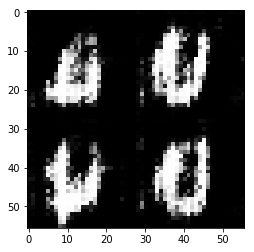

Epoch   0/2    Discriminator Loss:  1.221 Generator Loss:  1.972
Epoch   0/2    Discriminator Loss:  1.254 Generator Loss:  1.302


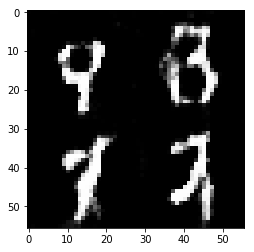

Epoch   0/2    Discriminator Loss:  1.217 Generator Loss:  1.204
Epoch   0/2    Discriminator Loss:  1.096 Generator Loss:  1.502


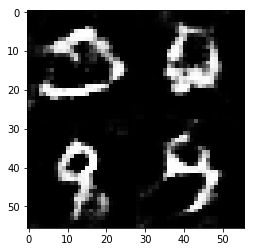

Epoch   0/2    Discriminator Loss:  1.187 Generator Loss:  1.288
Epoch   0/2    Discriminator Loss:  1.203 Generator Loss:  1.284


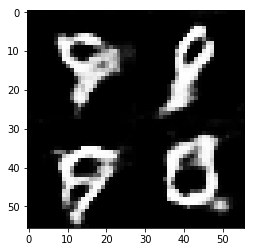

Epoch   0/2    Discriminator Loss:  1.173 Generator Loss:  1.983
Epoch   0/2    Discriminator Loss:  1.102 Generator Loss:  1.564


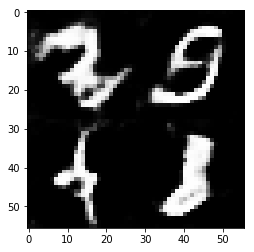

Epoch   0/2    Discriminator Loss:  1.132 Generator Loss:  0.997
Epoch   0/2    Discriminator Loss:  1.153 Generator Loss:  1.499


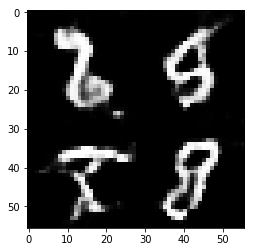

Epoch   1/2    Discriminator Loss:  1.074 Generator Loss:  1.177
Epoch   1/2    Discriminator Loss:  1.142 Generator Loss:  2.125


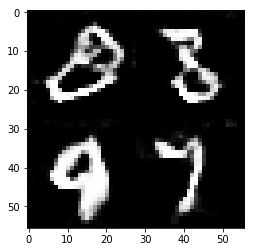

Epoch   1/2    Discriminator Loss:  1.123 Generator Loss:  1.456
Epoch   1/2    Discriminator Loss:  0.878 Generator Loss:  0.983


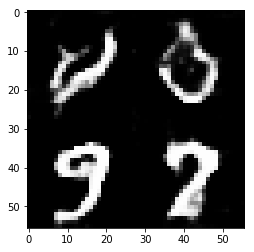

Epoch   1/2    Discriminator Loss:  1.077 Generator Loss:  1.883
Epoch   1/2    Discriminator Loss:  1.193 Generator Loss:  1.538


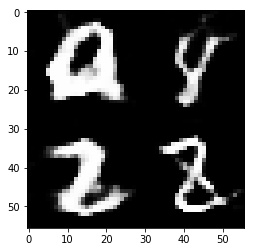

Epoch   1/2    Discriminator Loss:  1.000 Generator Loss:  1.625
Epoch   1/2    Discriminator Loss:  0.997 Generator Loss:  1.212


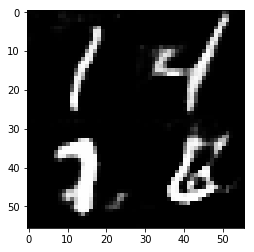

Epoch   1/2    Discriminator Loss:  0.788 Generator Loss:  1.652
Epoch   1/2    Discriminator Loss:  1.004 Generator Loss:  1.186


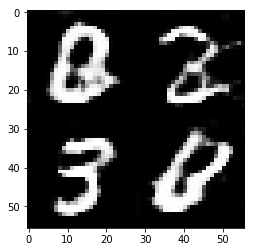

Epoch   1/2    Discriminator Loss:  0.808 Generator Loss:  1.838
Epoch   1/2    Discriminator Loss:  0.874 Generator Loss:  1.001


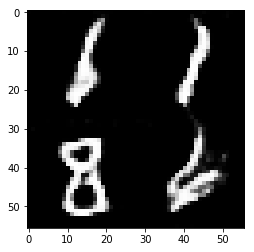

In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch   0/1    Discriminator Loss:  0.596 Generator Loss:  4.107
Epoch   0/1    Discriminator Loss:  1.179 Generator Loss:  1.734


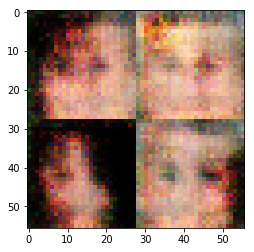

Epoch   0/1    Discriminator Loss:  1.129 Generator Loss:  1.154
Epoch   0/1    Discriminator Loss:  0.824 Generator Loss:  1.475


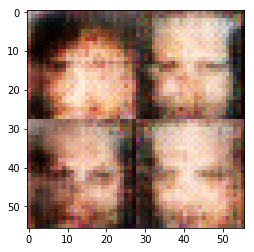

Epoch   0/1    Discriminator Loss:  0.894 Generator Loss:  2.564
Epoch   0/1    Discriminator Loss:  1.073 Generator Loss:  1.425


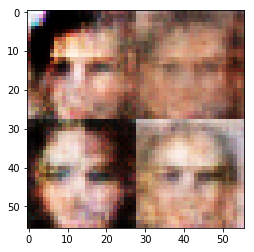

Epoch   0/1    Discriminator Loss:  0.884 Generator Loss:  1.466
Epoch   0/1    Discriminator Loss:  0.954 Generator Loss:  2.161


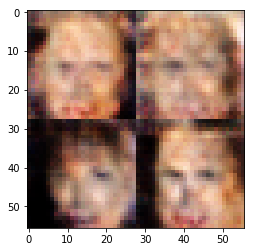

Epoch   0/1    Discriminator Loss:  1.345 Generator Loss:  3.158
Epoch   0/1    Discriminator Loss:  0.933 Generator Loss:  1.954


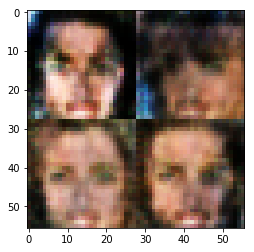

Epoch   0/1    Discriminator Loss:  0.809 Generator Loss:  1.487
Epoch   0/1    Discriminator Loss:  1.054 Generator Loss:  1.437


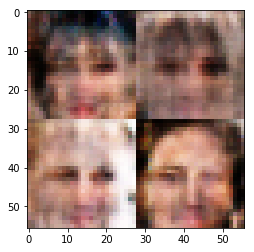

Epoch   0/1    Discriminator Loss:  0.996 Generator Loss:  1.077
Epoch   0/1    Discriminator Loss:  0.979 Generator Loss:  1.003


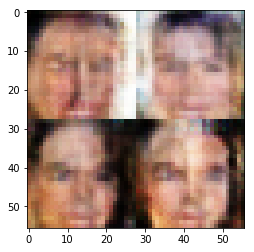

Epoch   0/1    Discriminator Loss:  0.969 Generator Loss:  1.466
Epoch   0/1    Discriminator Loss:  0.998 Generator Loss:  0.931


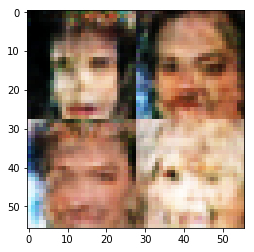

Epoch   0/1    Discriminator Loss:  1.050 Generator Loss:  1.121
Epoch   0/1    Discriminator Loss:  1.057 Generator Loss:  1.069


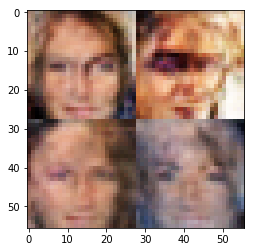

Epoch   0/1    Discriminator Loss:  1.030 Generator Loss:  1.664
Epoch   0/1    Discriminator Loss:  0.896 Generator Loss:  1.337


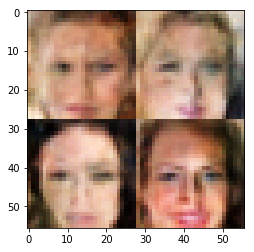

Epoch   0/1    Discriminator Loss:  1.081 Generator Loss:  0.877
Epoch   0/1    Discriminator Loss:  1.040 Generator Loss:  1.380


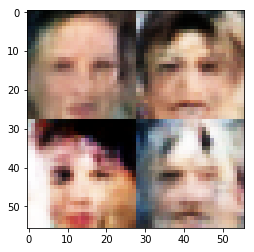

Epoch   0/1    Discriminator Loss:  0.916 Generator Loss:  1.450
Epoch   0/1    Discriminator Loss:  1.267 Generator Loss:  0.897


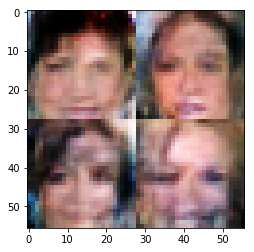

Epoch   0/1    Discriminator Loss:  0.744 Generator Loss:  1.595
Epoch   0/1    Discriminator Loss:  1.403 Generator Loss:  2.167


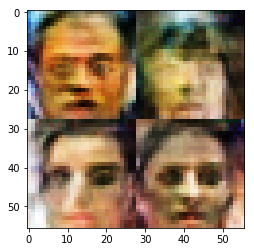

Epoch   0/1    Discriminator Loss:  0.670 Generator Loss:  1.728
Epoch   0/1    Discriminator Loss:  1.164 Generator Loss:  1.067


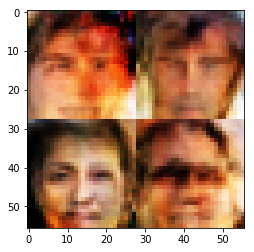

Epoch   0/1    Discriminator Loss:  0.854 Generator Loss:  1.592
Epoch   0/1    Discriminator Loss:  0.741 Generator Loss:  1.586


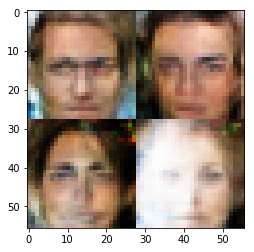

Epoch   0/1    Discriminator Loss:  1.502 Generator Loss:  0.723
Epoch   0/1    Discriminator Loss:  0.904 Generator Loss:  1.549


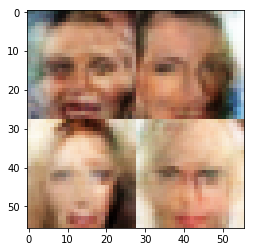

Epoch   0/1    Discriminator Loss:  1.215 Generator Loss:  1.116
Epoch   0/1    Discriminator Loss:  0.984 Generator Loss:  1.511


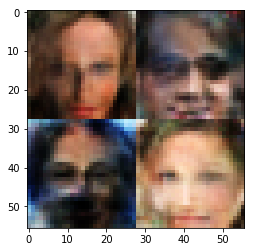

Epoch   0/1    Discriminator Loss:  1.281 Generator Loss:  1.423
Epoch   0/1    Discriminator Loss:  0.837 Generator Loss:  1.295


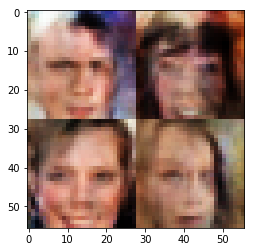

Epoch   0/1    Discriminator Loss:  1.031 Generator Loss:  1.222
Epoch   0/1    Discriminator Loss:  0.978 Generator Loss:  2.015


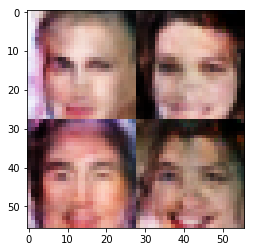

Epoch   0/1    Discriminator Loss:  0.705 Generator Loss:  2.073
Epoch   0/1    Discriminator Loss:  2.217 Generator Loss:  2.196


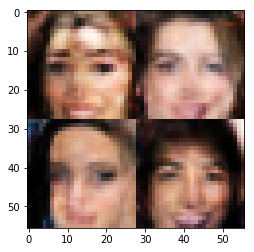

In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.